# Creating a Neural Network

In this task, we will create a fully connected neural network using low-level TensorFlow mechanisms.

The architecture of the neural network is shown in the diagram below. As you can see, it consists of one input layer, two hidden layers, and one output layer. A sigmoid function will be used as the activation function in the hidden layers, while softmax will be used in the output layer.

## Neural Network Architecture

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## About the MNIST Dataset

We will train this neural network using the MNIST dataset. This dataset consists of a large number of handwritten digit images with a size of $28 \times 28$ pixels. Each pixel has a value ranging from 0 to 255.

As before, the dataset will be split into training and testing sets. Additionally, we will normalize all the images so that the pixel values fall within the range of 0 to 1 by dividing each pixel's intensity by 255.

Moreover, the neural network architecture expects a vector as input. However, in our case, each dataset sample is represented as a matrix. What should we do? In this task, we will "flatten" the $28 \times 28$ matrix into a vector consisting of 784 elements.

<img src="https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png" alt="MNIST Dataset" style="width: 400px;"/>

More information about the dataset can be found [here](http://yann.lecun.com/exdb/mnist/).

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras as K
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # total number of classes, in our case these are digits from 0 to 9
num_features = 784 # number of attributes in the input vector, 28 * 28 = 784

learning_rate = 0.001 # learning rate of the neural network
training_steps = 3000  # maximum number of epochs
batch_size = 256 # we will update network weights not on the entire dataset, but on a random subset of batch_size elements
display_step = 100 # every 100 iterations we will display the current loss function value and accuracy

n_hidden_1 = 128 # number of neurons in the 1st layer
n_hidden_2 = 256 # number of neurons in the 2nd layer

In [3]:
# Loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Converting integer pixels to float32 type
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Transforming 28x28 pixel matrices into a vector of 784 elements
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizing pixel values
x_train, x_test = x_train / 255., x_test / 255.

# Shuffling the training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Creating the neural network

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # First layer with 128 neurons
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Second layer with 256 neurons
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Output layer
    self.output = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Passing data through the first two layers and the output layer with the softmax activation function
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    return self.output(x2, activation=1)

In [5]:
# Cross-entropy is convenient as the loss function in this case
def cross_entropy(y_pred, y_true):
    # Encode labels in one-hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# We use accuracy as the quality metric
def accuracy(y_pred, y_true):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.argmax(tf.one_hot(y_true, depth=y_pred.shape[-1]), axis=1)
    
    correct_predictions = tf.equal(y_pred_labels, y_true_labels)

    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [6]:
# Create an instance of the neural network
neural_net = NN(name="mnist")

# Neural network training function
def train(neural_net, input_x, output_y):
  # We will use stochastic gradient descent for adjusting the network weights
  optimizer = tf.optimizers.SGD(learning_rate)

  # Enable automatic differentiation
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Get the list of trainable parameters
    trainable_variables = neural_net.trainable_variables
    # Compute the gradient values for these parameters
    gradients = g.gradient(loss, trainable_variables)
      
    # Update the parameters
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

In [7]:
# Training the network

loss_history = []  # Every display_step steps, store the current network error in this list
accuracy_history = []  # Every display_step steps, store the current network accuracy in this list

# In this loop, we will train the neural network
# Take a random subset from the training dataset train_data, on which
# training will occur. Use the take method available for the training dataset.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Update the neural network weights
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss.numpy())

        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)  # Store the current accuracy

        print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc:.4f}")

Step 100, Loss: 279.5254, Accuracy: 0.6992
Step 200, Loss: 212.6209, Accuracy: 0.7812
Step 300, Loss: 200.6315, Accuracy: 0.7891
Step 400, Loss: 176.0438, Accuracy: 0.8125
Step 500, Loss: 169.3653, Accuracy: 0.7891
Step 600, Loss: 135.2182, Accuracy: 0.8555
Step 700, Loss: 140.5752, Accuracy: 0.8477
Step 800, Loss: 126.0382, Accuracy: 0.8438
Step 900, Loss: 94.9987, Accuracy: 0.8906
Step 1000, Loss: 96.0723, Accuracy: 0.8594
Step 1100, Loss: 79.5581, Accuracy: 0.8828
Step 1200, Loss: 79.4632, Accuracy: 0.8984
Step 1300, Loss: 118.8969, Accuracy: 0.8789
Step 1400, Loss: 73.6317, Accuracy: 0.9180
Step 1500, Loss: 72.8646, Accuracy: 0.9062
Step 1600, Loss: 81.6150, Accuracy: 0.9062
Step 1700, Loss: 82.5160, Accuracy: 0.9141
Step 1800, Loss: 82.7313, Accuracy: 0.8867
Step 1900, Loss: 74.2002, Accuracy: 0.9219
Step 2000, Loss: 79.6035, Accuracy: 0.9023
Step 2100, Loss: 73.0770, Accuracy: 0.9141
Step 2200, Loss: 69.1356, Accuracy: 0.9062
Step 2300, Loss: 58.7082, Accuracy: 0.9375
Step 2400, 

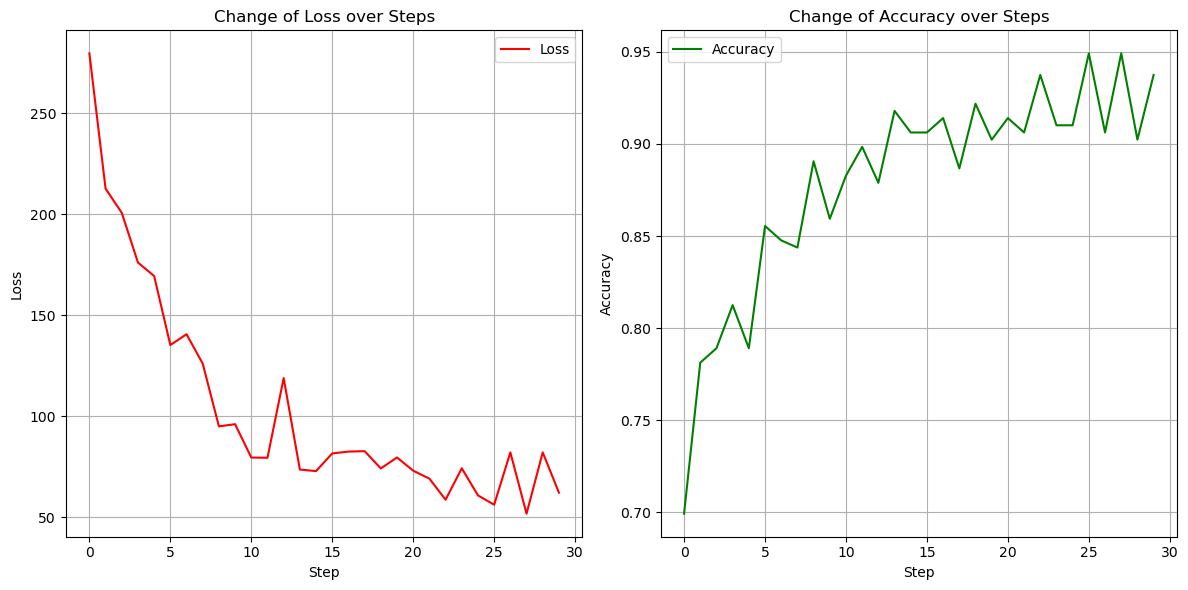

In [8]:
# Plot the graphs of accuracy and loss change over steps
# If everything is done correctly, accuracy should increase, and loss should decrease

# Plot the loss function graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First plot
plt.plot(loss_history, label="Loss", color="red")
plt.title("Change of Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)  # Second plot
plt.plot(accuracy_history, label="Accuracy", color="green")
plt.title("Change of Accuracy over Steps")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
# Compute the accuracy of the trained neural network
predicted_train = neural_net(x_train)
accuracy_train = accuracy(predicted_train, y_train)
print(f"Accuracy of the trained neural network: {accuracy_train}")

# Test the model on test data
predicted_test = neural_net(x_test)
accuracy_test = accuracy(predicted_test, y_test)
print(f"Accuracy of the neural network on test data: {accuracy_test}")

Accuracy of the trained neural network: 0.9211333394050598
Accuracy of the neural network on test data: 0.9021000266075134


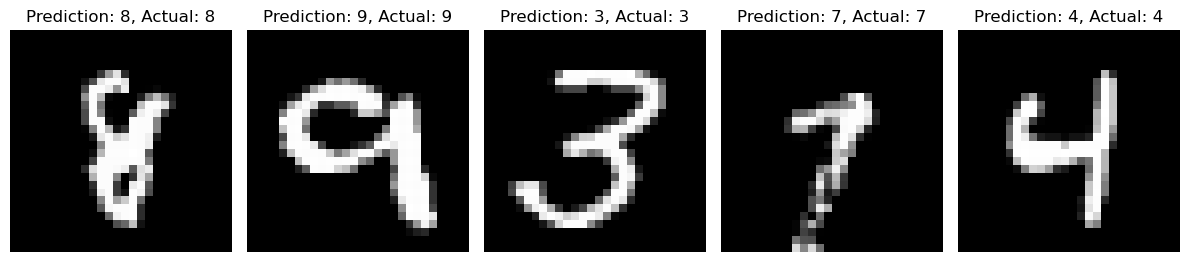

In [10]:
# Test the trained neural network on 10 images. Take 5 random images from the test set
# and pass them to the neural network.
# Display the images and write the neural network's answer next to them.
# Make a conclusion about whether your neural network makes mistakes, and if so, how often?

random_indices = np.random.choice(range(len(x_test)), 5)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

predictions = neural_net(random_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(random_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Prediction: {predicted_labels[i]}, Actual: {random_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Conclusion
The accuracy of the neural network on the test data is 90.2%.